In [1]:
from comet_ml import API
import pandas as pd
import os
import sys
import pickle
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, average_precision_score

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))

from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot, calibrate_display
from feature_engineering import preprocessing

test_data1 = pd.read_csv('../data/derivatives/test_data_saison_eli.csv')
test_data2 = pd.read_csv('../data/derivatives/test_data_saison_reg.csv')

In [2]:
def visualisation(model_name, best_model, y_probs, y_test, X_test):
    y_test = pd.Series(y_test)
    CLFS = [[[best_model], X_test, model_name] ]
    Ys=[[model_name, y_probs[:,1], "blue", True] ]
    
    print(f"Résultats pour le modèle : {model_name}")

    ROC_plot(y_test, Ys)
    Centiles_plot(y_test, Ys)
    cumulative_centiles_plot(y_test, Ys)
    calibrate_display(CLFS, y_test, n_bin = 40)

COMET INFO: Downloading registry model 'xgboost', version '1.4.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\xgboost' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, User

roc_auc_score for xgboost: 0.8130643993456665
average_precision for xgboost: 0.3680251224834943
log_loss for xgboost: 0.244333797969171
brier_score for xgboost: 0.06983909093068022
Résultats pour le modèle : xgboost
Métrique AUC : {'xgboost': 0.8130643993456665}


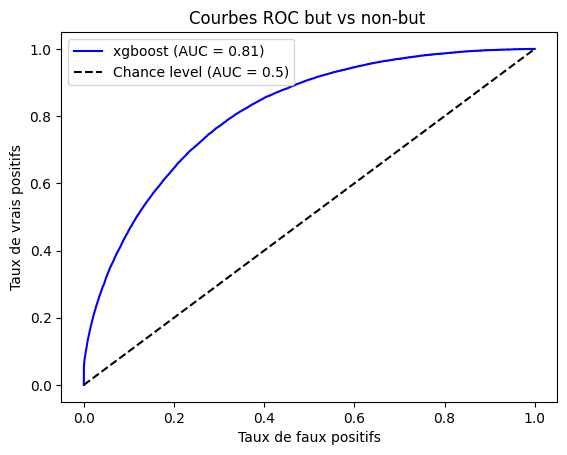

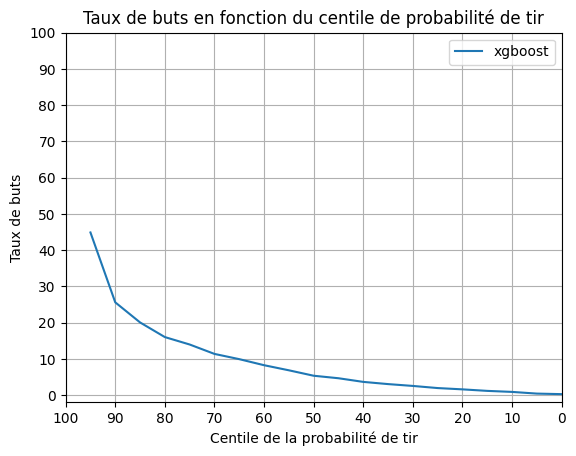

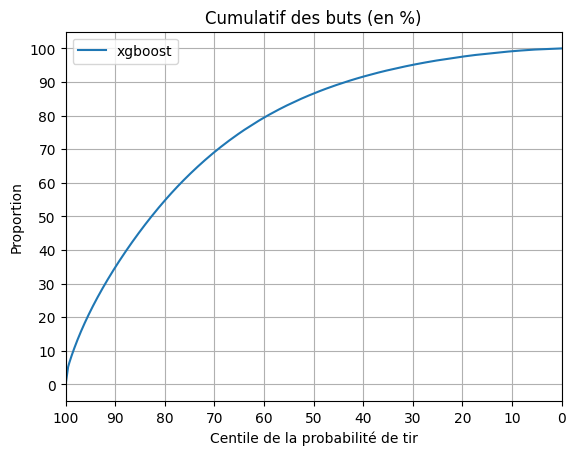

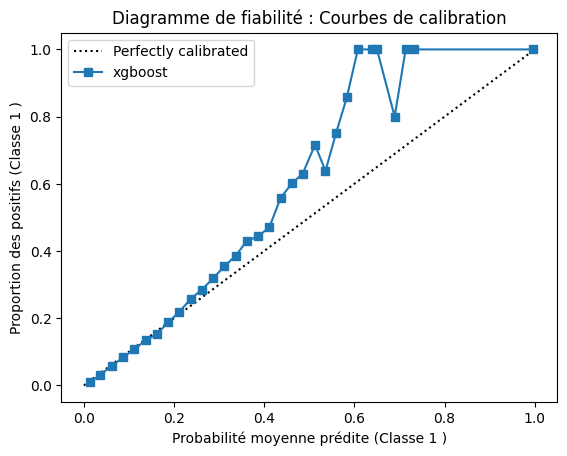

COMET INFO: Downloading registry model 'logistic_reg_angle', version '1.0.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_angle' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
COMET INFO: Downloading registry model 'logistic_reg_dist-angle', version '1.0.0', stage None from workspace 'me-pic'...


An error occurred: X has 33 features, but LogisticRegression is expecting 1 features as input.


COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_dist-angle' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logistic_reg_distance', version '1.0.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_distance' ...
COMET INFO: done!


An error occurred: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- away_team_skater_count
- changement_angle_tir
- coord_x
- coord_y
- distance_from_last_event
- ...
Feature names seen at fit time, yet now missing:
- angle_goal
- distance_goal

An error occurred: X has 33 features, but LogisticRegression is expecting 1 features as input.


c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [3]:
API_KEY = os.environ.get('COMET_API_KEY')
project_name = "milestone-2"
workspace = "me-pic"

api = API(api_key=API_KEY)

model_list = [("xgboost", "1.4.0"),
              ("logistic_reg_angle", "1.0.0"),
              ('logistic_reg_dist-angle', "1.0.0"),
              ('logistic_reg_distance', "1.0.0")
              # Ajoutez d'autres modèles ici
             ]

for model_name, model_version in model_list:
    try:

        output_path = f"../model/{model_name}"
        
        api.download_registry_model(workspace, model_name, model_version, output_path= output_path , expand=True)
        
        file_name = os.listdir(f'../model/{model_name}')
        
        with open(os.path.join(output_path, file_name[0]) , 'rb') as file:
            model = pickle.load(file)
        
        X, y = preprocessing(test_data1, 'is_goal')
        
        predictions = model.predict_proba(X)
        
        metrics = roc_auc_score(y, predictions[:, 1])
        print(f"roc_auc_score for {model_name}: {metrics}")

        metrics = average_precision_score(y, predictions[:, 1])
        print(f"average_precision for {model_name}: {metrics}")

        metrics = log_loss(y, predictions)
        print(f"log_loss for {model_name}: {metrics}")

        metrics= brier_score_loss(y, predictions[:, 1])
        print(f"brier_score for {model_name}: {metrics}")

        visualisation(model_name, model, predictions, y, X)

    except Exception as e:
            print(f"An error occurred: {e}")


